### 0. Data aquisition

Get the training data from 'Walmart Recruiting: Trip Type Classification' competition:
https://www.kaggle.com/c/walmart-recruiting-trip-type-classification/data

Note 1: you can also pass this assignment if you will provide notebook with 0.55 log loss or better result on 10-fold cross-validation. 

Note 2: if this competition is your project, consider this assignment as first steps in it. 



In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy

import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.cross_validation import train_test_split, KFold , cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
from sklearn.grid_search import GridSearchCV

from sklearn.preprocessing import scale
%matplotlib inline

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [6]:
url_train = '/home/hpish/Data/train.csv'
url_test = '/home/hpish/Data/test 2.csv'
train = pd.read_csv(url_train)
test = pd.read_csv(url_test)

### 1. Preliminary analysis

In [3]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000
1,30,7,Friday,60538815980,1,SHOES,8931
2,30,7,Friday,7410811099,1,PERSONAL CARE,4504
3,26,8,Friday,2238403510,2,PAINT AND ACCESSORIES,3565
4,26,8,Friday,2006613744,2,PAINT AND ACCESSORIES,1017


In [4]:
test.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,1,Friday,72503389714,1,SHOES,3002
1,1,Friday,1707710732,1,DAIRY,1526
2,1,Friday,89470001026,1,DAIRY,1431
3,1,Friday,88491211470,1,GROCERY DRY GOODS,3555
4,2,Friday,2840015224,1,DSD GROCERY,4408


Give summary of train features. 

— Which of them are numerical and categorical? 

— What distributions do they have? Are distributions identical on test and train? 

— What features contain missing values? What's your guess why?

Note: Pandas library can be very handy.

TripType:             -categorical, our class label <br />
VisitNumber           -id of a trip, categorical <br />
weekday               -categorical <br />
ScanCount             -numerical, number of bought(returned) products <br />
DepartmentDescription -categorical <br />
FinelineNumber        -categorical <br />


Now to distributions:

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:894: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


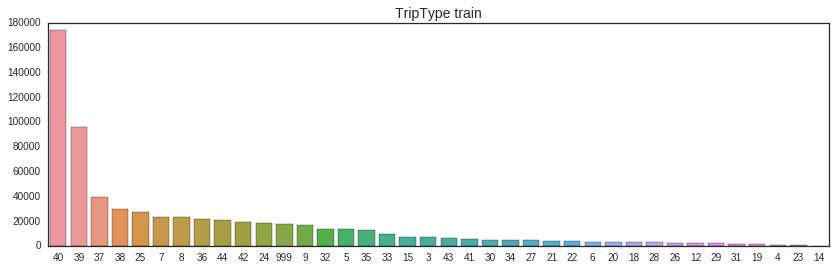

In [5]:
target_counts = train.TripType.value_counts()

plt.figure(figsize=(14,4))
x = target_counts.index
y = target_counts.values
sns.barplot(x = x, y = y)
plt.title('TripType train', fontsize = 14)

Looks like a power law distribution

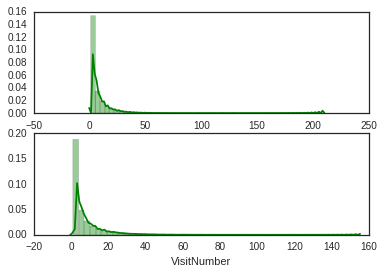

In [37]:

f,(ax1,ax2) = f, (ax1, ax2) = plt.subplots(2)
x = train.VisitNumber.value_counts()
sns.distplot(x, color="g",ax=ax1)



y = test.VisitNumber.value_counts()
sns.distplot(y, color="g",ax=ax2)



Both also look like a power law at first, but there is some bump in the end. Anomaly?

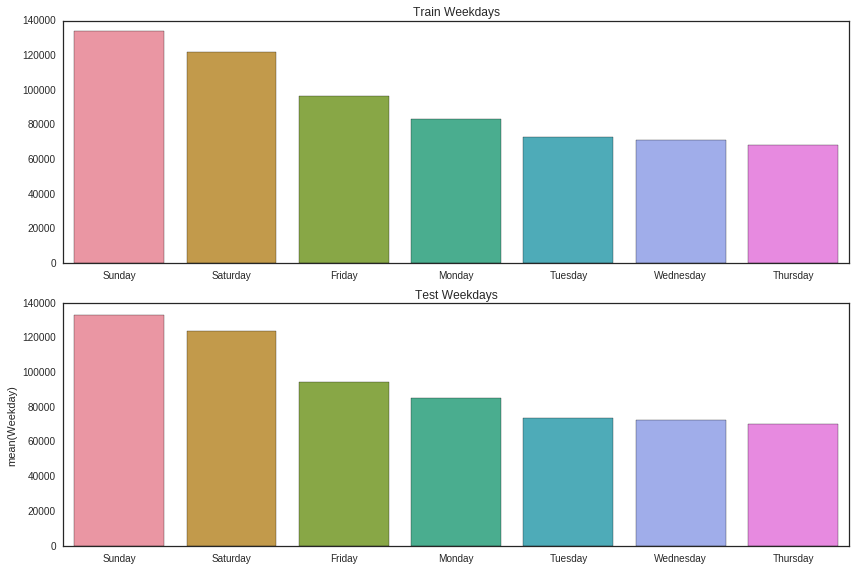

In [28]:
Traincount = train.Weekday.value_counts()
TestCount = test.Weekday.value_counts()

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
x = Traincount.index
y = Traincount.values
sns.barplot(x = x, y = y)
plt.title('Train Weekdays');

plt.subplot(2,1,2)
y = TestCount[x]
sns.barplot(x = x, y = y)
plt.title('Test Weekdays'); 

plt.tight_layout()

Not too vivid a distribution to pick. Classes are roughly similar

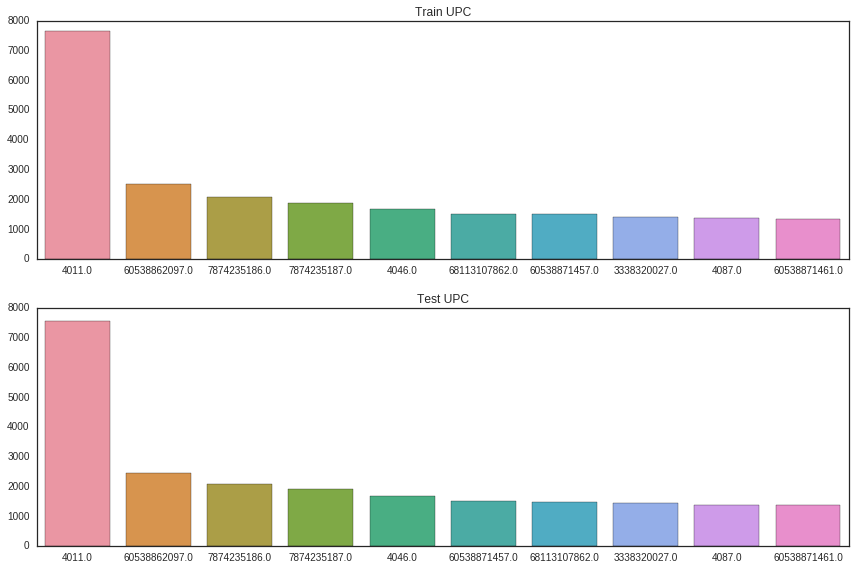

In [40]:
Traicount = train.Upc.value_counts()
Testcount = test.Upc.value_counts()

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
x = Traicount.index[:10]
y = Traicount.values[:10]
sns.barplot(x = x, y = y)
plt.title('Train UPC')

plt.subplot(2,1,2)
x = Testcount.index[:10]
y = Testcount.values[:10]
sns.barplot(x = x, y = y)
plt.title('Test UPC')
plt.tight_layout(h_pad = 2)




mostly looks like distribution of 1 class differs significantly from others (fairly evenly distributed)

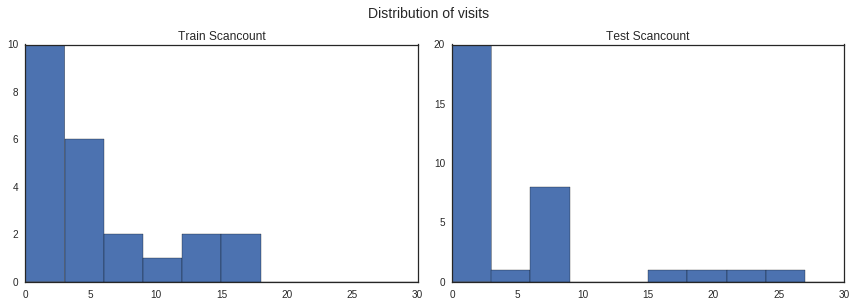

In [41]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(train.ScanCount.value_counts().ravel(), range = (0,30))
plt.title('Train Scancount')
plt.subplot(1,2,2)
plt.hist(test.ScanCount.value_counts().ravel(), range = (0,30))
plt.title('Test Scancount')
plt.tight_layout()
plt.suptitle('Distribution of visits', y = 1.05, fontsize = 14)

Doesn't seem to be distributed equally. co clear pattern here

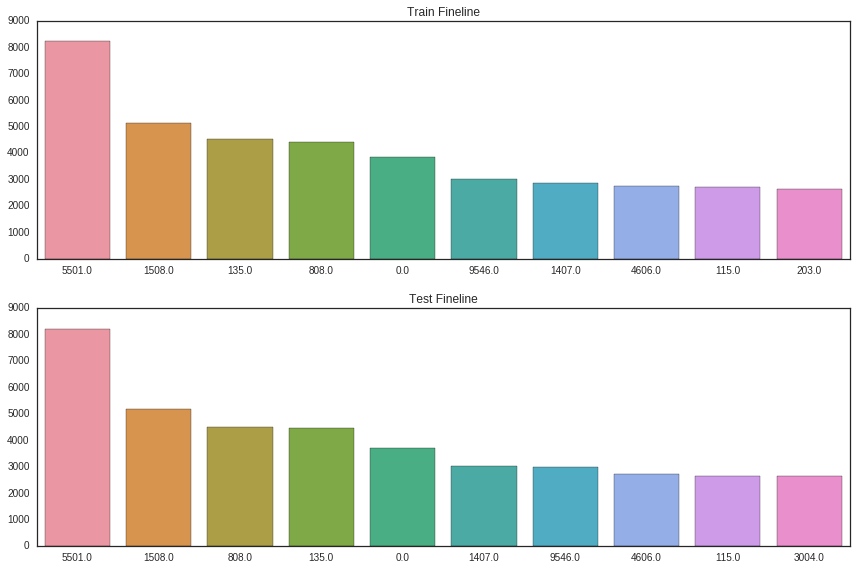

In [45]:
Traicount = train.FinelineNumber.value_counts()
Testcount = test.FinelineNumber.value_counts()

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
x = Traicount.index[:10]
y = Traicount.values[:10]
sns.barplot(x = x, y = y)
plt.title('Train Fineline')

plt.subplot(2,1,2)
x = Testcount.index[:10]
y = Testcount.values[:10]
sns.barplot(x = x, y = y)
plt.title('Test Fineline')
plt.tight_layout(h_pad = 2)


We can see that popularity of item does not have any particular correlation with its number(cathegory?)

### 2. Data preprocessing and feature engineering

— Missing values. How do you choose to impute them? Why?

— String variables. Implement label and one-hot encoding. For what models it makes a difference? (Note: it may be better to use Pandas get_dummies method to one-hot encoder in sklearn).

— Combine observations by VisitNumber (Pandas groupby method can be very handy in that case). Make feature vector for each VisitNumber.  

— Split training data into even new_train and evaluation sets using train_test_split from sklearn. Fix random state for reproducibility of your results. 

— Choose cross-validation 5-fold split for your data (3-fold if your PC is not so fast). Do not forget to specify random state for your results reproducibility. 

In [18]:
print('---Nans in columns---', '\n')
for col in train.columns:
    print(col + ": {}".format(pd.isnull(train[col]).sum()))

('---Nans in columns---', '\n')
TripType: 0
VisitNumber: 0
Weekday: 0
Upc: 4129
ScanCount: 0
DepartmentDescription: 1361
FinelineNumber: 4129


In [20]:
print('---Nans in columns---', '\n')
for col in test.columns:
    print(col + ": {}".format(pd.isnull(test[col]).sum()))

('---Nans in columns---', '\n')
VisitNumber: 0
Weekday: 0
Upc: 3986
ScanCount: 0
DepartmentDescription: 1328
FinelineNumber: 3986


In [10]:
train.dropna(inplace=True)
test.dropna(inplace=True)

So we have some NaNs in Up,Scancount and FinelineNumber
They are all categorical features, and additionally describe certain products and departments, nut just some random metric.Also, Upc and Fineline number miss the same amount of data-in the same rows, most likely. So by imputing them by some common value, we risk breaking relations found between features. 
Also there are only a few of them, and given the size of dataset, we can safely drop them.

We should definitely encode with integers all word-like cathegorical features. Very few ML algorithms can handle them properly

In [11]:
from sklearn.preprocessing import LabelEncoder
lab = LabelEncoder()
lab.fit(train['Weekday'])
train['Weekday'] = lab.transform(train['Weekday'])
test['Weekday'] = lab.transform(test['Weekday'])
lab.fit(train['DepartmentDescription'])
train['DepartmentDescription'] = lab.transform(train['DepartmentDescription'])
test['DepartmentDescription'] = lab.transform(test['DepartmentDescription'])

In [12]:
train_enc =train
test_enc = test
cols = ['Weekday','DepartmentDescription']
for c in cols:
    train_enc = pd.get_dummies(train, columns = [c])
    test_enc = pd.get_dummies(test, columns = [c])


For some algorithms all categorical features should be transformed to be of use.
Knowing that we need to calculate KNN classifier, we should also encode other features for later. Some Ml methods cannot ploperly learn on categorical features, unless they are binary. Naive Bayes is a good example. Or any Continious models, like logit regression or SVM, as they treat labels as monotonic or partly monotonic functions

In [6]:
train_byVisitN = train.groupby("VisitNumber")
train_byVisitN.size().keys()
y = train_byVisitN.size().keys()
x = np.array(train_byVisitN.size())
type(x)


numpy.ndarray

Let's split our train data randomly in half

In [13]:

seed =10
y = train['TripType']
x = train.ix[:,1:]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5,random_state=seed)


In [14]:
seed = 25
x_enc = train_enc.ix[:,1:]
y_enc = y = train_enc['TripType']
Xe_train, Xe_test, ye_train, ye_test = train_test_split(x_enc, y_enc, test_size=0.5,random_state=seed)


We can split data into 3-cv dataset whithout actually doing(by labels)

In [15]:
seed = 55
a = train.shape[0]
Kf =  KFold(a, n_folds = 3, random_state = seed)

### 3. KNN-classifier

— Try KNN classifier on the obtained features. Report accuracy and logarithmic loss (mean and std across the folds). How does this evaluation metrics change depending on neighbors number? Depending on distance metric? 

— Show normalized confusion matrix for the best obtained model performance on the evaluation set. How does it differ from cross-validation score?

In [38]:
from sklearn.learning_curve import validation_curve
from sklearn.neighbors import KNeighborsClassifier as KNN

In [143]:

def Val_curve(x,y,rng,scoring,param):
    param_range = rng
    train_scores, test_scores = validation_curve(
    KNN(), x, y, param_name= param, param_range=param_range,
    cv=3, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Validation Curve with KNN")
    plt.xlabel("$KNN$")
    plt.ylabel("Score")
    plt.xlim(min(param_range), max(param_range))
    plt.plot(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()

Here we plot accuracy and number of neighbors.The transparent "aura" around lines is it's deviation between folds

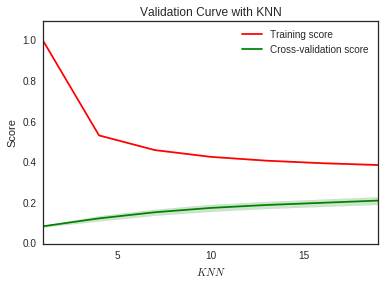

In [139]:
Val_curve(x,y,rng = range(1, 20, 3), scoring = 'accuracy' , param = "n_neighbors")

and here we plot the change of distance metric- it's all the Minkosky's metric, but we change our dimensions
The difference is negligible.

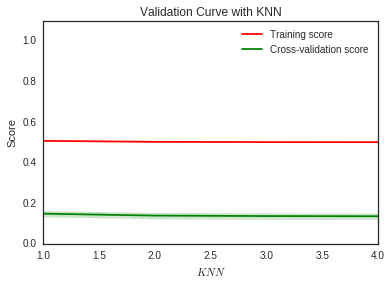

In [140]:
Val_curve(x,y,rng = range(1, 5, 1), scoring = 'accuracy' , param = "p")

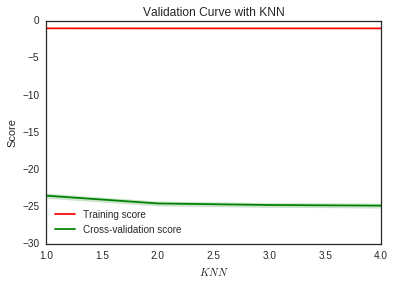

In [146]:
Val_curve(x,y,rng = range(1, 5, 1), scoring = 'log_loss' , param = "p")

In [ ]:
Here we watch the log-loss curve

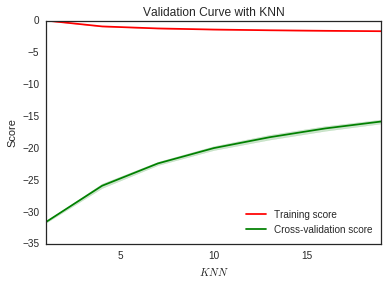

In [144]:
Val_curve(x,y,rng = range(1, 20, 3), scoring = 'log_loss' , param = "n_neighbors")

In [22]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    np.set_printoptions(precision=2)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(y_test))
    plt.xticks(tick_marks, y_test, rotation=45)
    plt.yticks(tick_marks, y_test)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Let's fit the classifier with best parameters. Judging by accuracy metric, it's safe to pick n_score =15.

In [12]:
Scores = dict()

In [13]:
knn = KNN(n_neighbors = 7, p = 1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)
Scores['KNN'] =[accuracy_score(y_test, y_pred),log_loss(y_test, y_proba)]
print(Scores['KNN'])

[0.28903481893717164, 12.840675939872526]


In [ ]:
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float16') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)


ERROR! Session/line number was not unique in database. History logging moved to new session 97
Normalized confusion matrix
[[  7.84e-01   2.92e-04   4.09e-03 ...,   2.33e-03   2.92e-03   5.40e-02]
 [  1.13e-02   1.43e-01   1.72e-01 ...,   0.00e+00   9.07e-03   6.80e-03]
 [  1.92e-02   7.06e-03   2.50e-01 ...,   1.77e-03   7.77e-03   1.48e-02]
 ..., 
 [  1.21e-02   3.19e-03   2.39e-02 ...,   1.40e-02   1.63e-02   1.43e-02]
 [  6.80e-03   2.17e-03   2.64e-02 ...,   2.66e-03   4.26e-02   1.10e-02]
 [  5.63e-02   1.39e-03   2.54e-02 ...,   1.62e-03   1.26e-02   1.89e-01]]


The confusion matrix should differ in that sense that we can distinguish patterns in the classification/misclassification among classes

### 4. Linear models 

— Try logistic regression and linear SVM on your features. Report accuracy and log loss. Compare it to KNN-classifier. How does performance differ whether you use data scaling or not? How does performance differ if you use on-hot or label encoded categorical features?

— Regularization. Play with l1 and l2 regularization parameters. Plot log loss score depending on different C values for l1 and l2 regularizations. What regualarization do you choose with which parameter? Why? 

— Show normalized confusion matrix for the best obtained model performance on the evaluation set. How does it differ from cross-validation score?

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale


Label encoding, not scaled

In [17]:
log = LogisticRegression()
scores_accur = cross_val_score(log, X_train, y_train, 
                         cv=3, scoring='accuracy').mean()
scores_logloss = cross_val_score(log, X_train, y_train, 
                         cv=3, scoring='log_loss').mean()
print([scores_accur,scores_logloss])

[0.27071629350970894, -4.6238699731354762]


One-hot encoding, not scaled

In [18]:
scores_accur = cross_val_score(log, Xe_train, ye_train, 
                         cv=3, scoring='accuracy').mean()
scores_logloss = cross_val_score(log, Xe_train, ye_train, 
                         cv=3, scoring='log_loss').mean()
print([scores_accur,scores_logloss])

[0.27066340847588533, -4.6000456162903518]


Label encoding, scaled

In [19]:
scores_accur = cross_val_score(log, scale(X_train), y_train, 
                         cv=3, scoring='accuracy').mean()
scores_logloss = cross_val_score(log, scale(X_train), y_train, 
                         cv=3, scoring='log_loss').mean()
print([scores_accur,scores_logloss])

/usr/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


[0.28617375778960158, -2.6783228576796994]


SVD is bound to be too computationally expensive on such a big dataset, and will take too long to compute. we can use alternative- SGD classifier with gradient descent. but we can only obtain accuracy for it

In [33]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()

One-hot scaled

In [24]:
scores_accur = cross_val_score(sgd, scale(Xe_train), y_train, 
                         cv=3, scoring='accuracy').mean()
print scores_accur

0.131335092123


Labelled scaled 

In [25]:
scores_accur = cross_val_score(sgd, scale(X_train), y_train, 
                         cv=3, scoring='accuracy').mean()
print scores_accur

0.19970534341


One-hot unscaled

In [28]:
scores_accur = cross_val_score(sgd, Xe_train, ye_train, 
                         cv=3, scoring='accuracy').mean()
print scores_accur

0.0173239096735


Labelled unscaled

In [29]:
scores_accur = cross_val_score(sgd, X_train, y_train, 
                         cv=3, scoring='accuracy').mean()
print scores_accur

0.100416320222


We can notice that Sgd does not provide the same accuracy as best logistic regression result

In [45]:
def Val_curve(clf,x,y,rng,scoring,param):
    param_range = rng
    train_scores, test_scores = validation_curve(
    clf, x, y, param_name= param, param_range=param_range,
    cv=3, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Validation Curve with alpha")
    plt.xlabel("$SGD$")
    plt.ylabel("Score")
    plt.xlim(min(param_range), max(param_range))
    plt.plot(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()

Plotting different C for L1 and L2 loss

L1

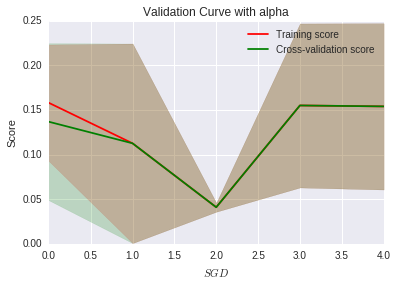

In [46]:
Val_curve(SGDClassifier(penalty = 'l1'),scale(x),y, rng = np.arange(0.0001,5,1),scoring = "accuracy", param = "alpha" )

L2

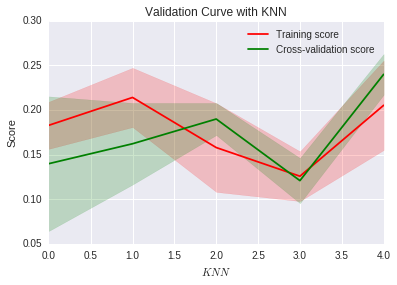

In [43]:
Val_curve(SGDClassifier(penalty = 'l2'),scale(x),y, rng = np.arange(0.0001,5,1),scoring = "accuracy", param = "alpha" )